In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from scipy import linalg, ndimage
from torchsummary import summary

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 100
train_data = FashionMNIST("./data", train = True, download = True,
                          transform=transforms.ToTensor())
test_data = FashionMNIST("./data", train = False, download = True,
                          transform=transforms.ToTensor())

train_data_loader = DataLoader(train_data, batch_size = batch_size, shuffle = False)
test_data_loader = DataLoader(train_data, batch_size = batch_size, shuffle = False)

width = 28
height = 28
input_size = width * height

In [3]:
def plot_images(batch, rows, cols, title = "", fig=None, ax=None):
    if ax == None:
        fig, ax = plt.subplots()
        fig.set_figheight(rows)
        fig.set_figwidth(cols)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title(title)
    ax.imshow(np.transpose(
        vutils.make_grid(batch[:(rows * cols)], nrow = rows, normalize = True).cpu(),
        (1, 2, 0)))

In [4]:
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self, out_size):
        super(FullyConnectedAutoencoder, self).__init__()
        self.elayer1 = nn.Linear(input_size, 256)
        self.ebatch1 = nn.BatchNorm1d(256)
        self.elayer2 = nn.Linear(256, 128)
        self.ebatch2 = nn.BatchNorm1d(128)
        self.elayer3 = nn.Linear(128, out_size)

        self.dlayer1 = nn.Linear(out_size, 128)
        self.dbatch1 = nn.BatchNorm1d(128)
        self.dlayer2 = nn.Linear(128, 256)
        self.dbatch2 = nn.BatchNorm1d(256)
        self.dlayer3 = nn.Linear(256, input_size)
    
    def encoder(self, x):
        y1 = F.elu(self.ebatch1(self.elayer1(x)))
        y2 = F.elu(self.ebatch2(self.elayer2(y1)))
        z = F.elu(self.elayer3(y2))
        return z

    def decoder(self, z):
        y1 = F.elu(self.dbatch1(self.dlayer1(z)))
        y2 = F.elu(self.dbatch2(self.dlayer2(y1)))
        x = torch.sigmoid(self.dlayer3(y2))
        return x
        
    def forward(self, x):
        x = x.view(-1, input_size)
        z = self.encoder(x)
        y = self.decoder(z)
        y = y.view(-1, 1, width, height)
        return y

class ConvolutionalAutoencoder(nn.Module):
    def __init__(self, out_size):
        super(ConvolutionalAutoencoder, self).__init__()
        self.econv1 = nn.Conv2d(1, 32, kernel_size = 5, bias = False)
        self.ebatch1 = nn.BatchNorm2d(32)
        self.econv2 = nn.Conv2d(32, 8, kernel_size = 5, bias = False)
        self.ebatch2 = nn.BatchNorm2d(8)
        self.econv3 = nn.Conv2d(8, out_size, kernel_size = 20, bias = True)

        self.dconv1 = nn.ConvTranspose2d(out_size, 8, kernel_size = 20, bias = True)
        self.dbatch1 = nn.BatchNorm2d(8)
        self.dconv2 = nn.ConvTranspose2d(8, 32, kernel_size = 5, bias = False)
        self.dbatch2 = nn.BatchNorm2d(32)
        self.dconv3 = nn.ConvTranspose2d(32, 1, kernel_size = 5, bias = False)

    def encoder(self, x):
        y1 = F.elu(self.ebatch1(self.econv1(x)))
        y2 = F.elu(self.ebatch2(self.econv2(y1)))
        z = F.elu(self.econv3(y2))
        return z

    def decoder(self, z):
        y1 = F.elu(self.dbatch1(self.dconv1(z)))
        y2 = F.elu(self.dbatch2(self.dconv2(y1)))
        x = torch.sigmoid(self.dconv3(y2))
        return x
     
    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y

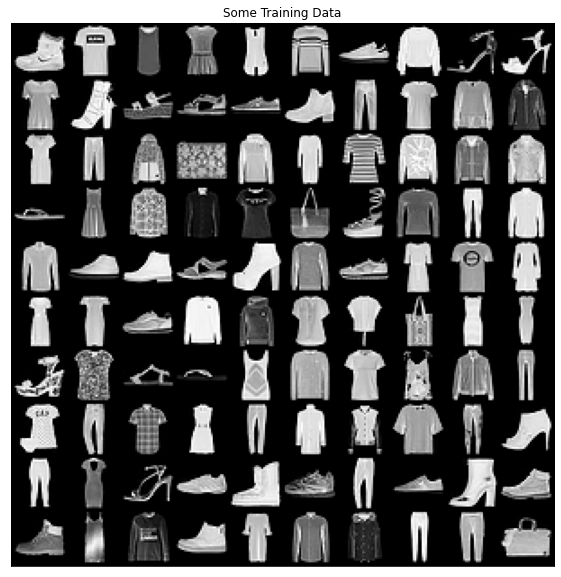

In [5]:
first_batch_train = next(iter(train_data_loader))
plot_images(first_batch_train[0], 10, 10, "Some Training Data")

# Problem 2

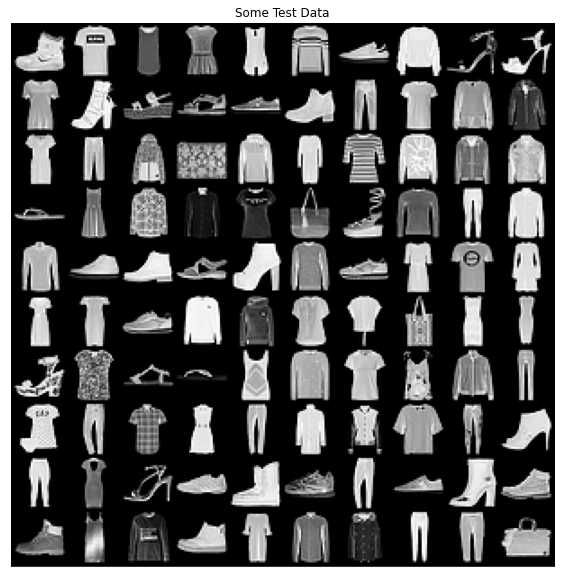

In [6]:
first_batch_test = next(iter(test_data_loader))
plot_images(first_batch_test[0], 10, 10, "Some Test Data")

In [7]:
### Load Convolutional Autoencoders
convAE16 = ConvolutionalAutoencoder(16)
convAE16.load_state_dict(torch.load('./convAE16.pth'))
convAE16.eval();

convAE32 = ConvolutionalAutoencoder(32)
convAE32.load_state_dict(torch.load('./convAE32.pth'))
convAE32.eval();

convAE128 = ConvolutionalAutoencoder(128)
convAE128.load_state_dict(torch.load('./convAE128.pth'))
convAE128.eval();

### Load Fully-connected Autoencoders
fcAE16 = FullyConnectedAutoencoder(16)
fcAE16.load_state_dict(torch.load('./fcAE16.pth'))
fcAE16.eval();

fcAE32 = FullyConnectedAutoencoder(32)
fcAE32.load_state_dict(torch.load('./fcAE32.pth'))
fcAE32.eval();

fcAE128 = FullyConnectedAutoencoder(128)
fcAE128.load_state_dict(torch.load('./fcAE128.pth'))
fcAE128.eval();

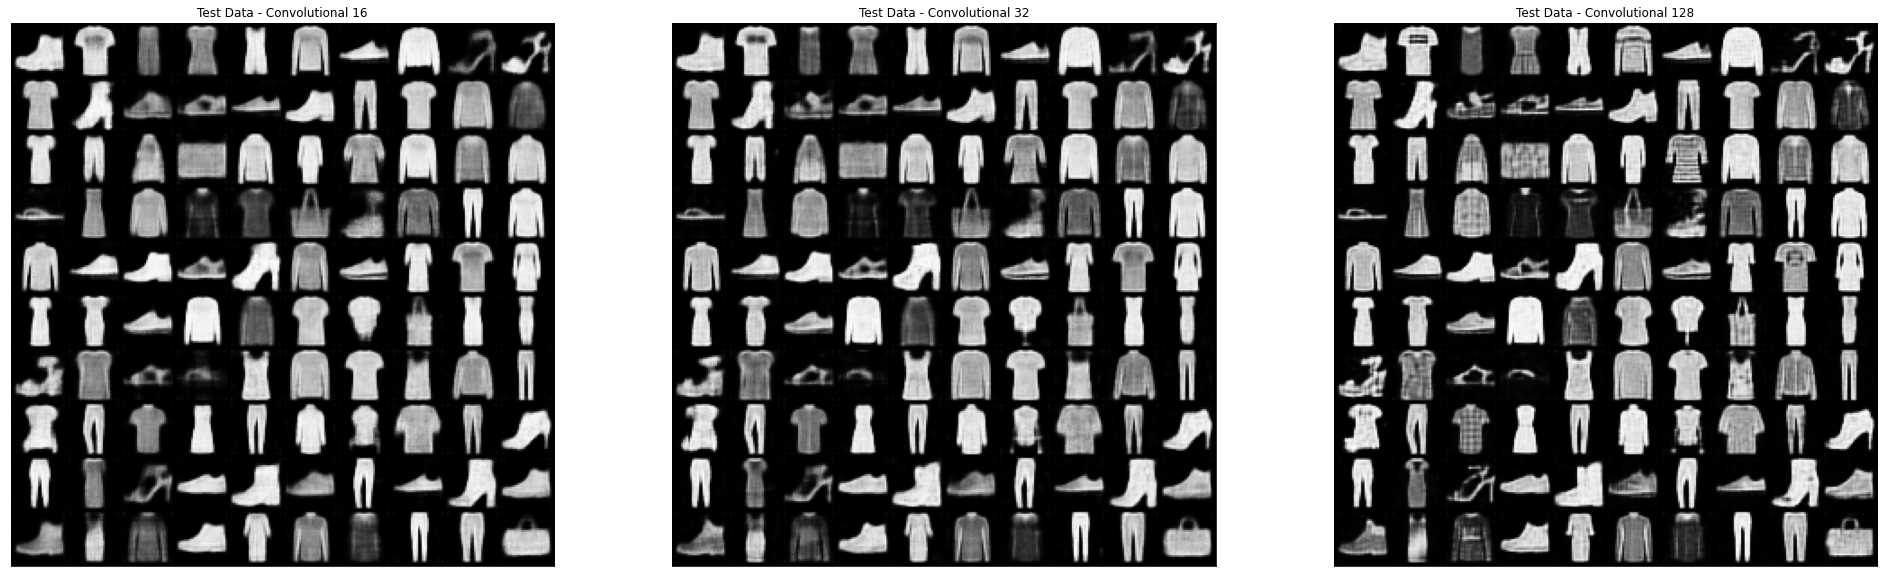

In [8]:
fig, axs = plt.subplots(1,3)
fig.set_figheight(10)
fig.set_figwidth(35)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

r_batch_conv16 = convAE16(first_batch_test[0])
r_batch_conv32 = convAE32(first_batch_test[0])
r_batch_conv128 = convAE128(first_batch_test[0])

plot_images(r_batch_conv16, 10, 10, "Test Data - Convolutional 16", fig, axs[0])
plot_images(r_batch_conv32, 10, 10, "Test Data - Convolutional 32", fig, axs[1])
plot_images(r_batch_conv128, 10, 10, "Test Data - Convolutional 128", fig, axs[2])

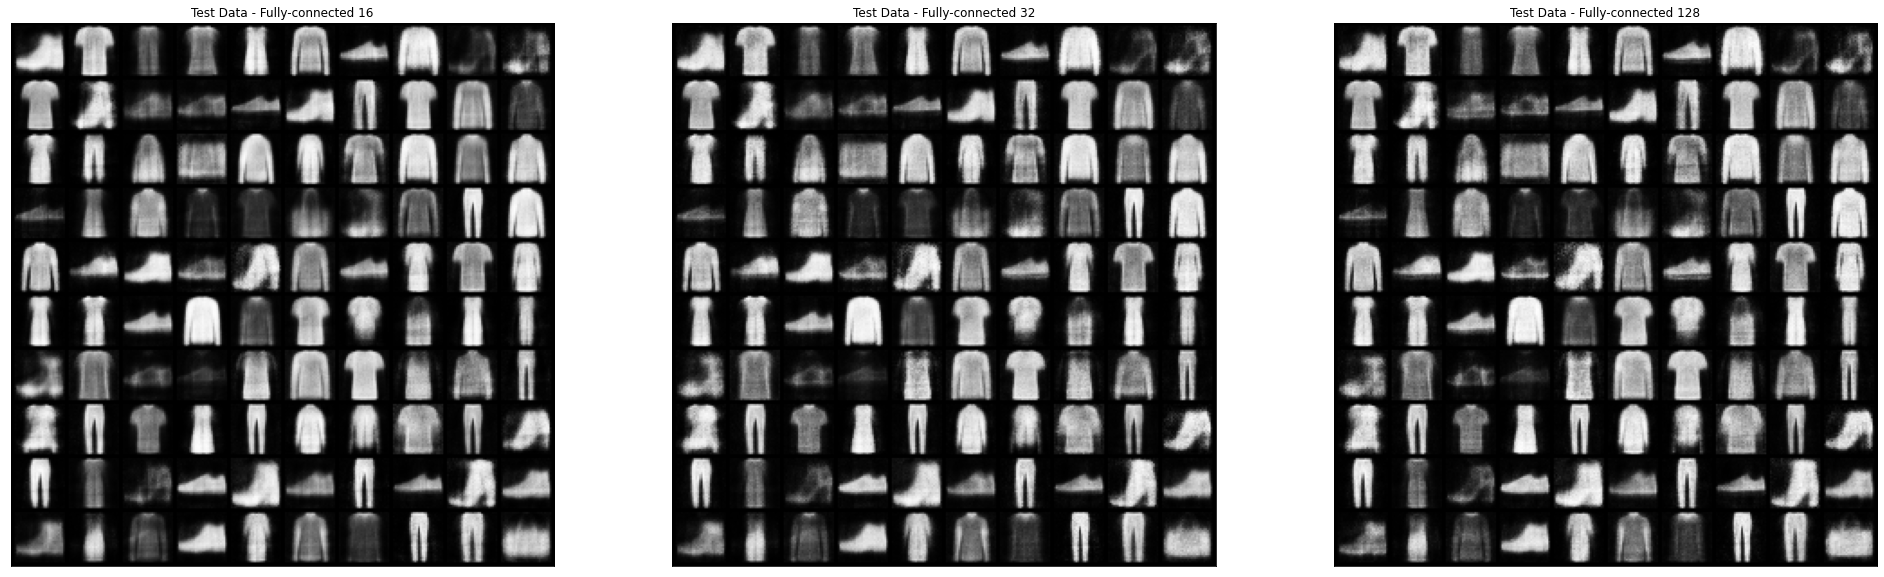

In [9]:
fig, axs = plt.subplots(1,3)
fig.set_figheight(10)
fig.set_figwidth(35)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

r_batch_fc16 = fcAE16(first_batch_test[0])
r_batch_fc32 = fcAE32(first_batch_test[0])
r_batch_fc128 = fcAE128(first_batch_test[0])

plot_images(r_batch_fc16, 10, 10, "Test Data - Fully-connected 16", fig, axs[0])
plot_images(r_batch_fc32, 10, 10, "Test Data - Fully-connected 32", fig, axs[1])
plot_images(r_batch_fc128, 10, 10, "Test Data - Fully-connected 128", fig, axs[2])

## Conclusion - Problem 2
From the 6 models, the best to encode/decode images is the convolutional of 128 dimension latent space, because it is able to reconstruct even details of the clothes. I would say that any of the convolutional models beat any of the fully connected models because the images are sharper and less blurry.

### Convolutional vs. Fully-connected
Overall it can be seen that convolutional neural networks do a better job to encode/decode the images than the fully-connected, though the difference is not hugh. Both types of architectures are able to encode and recover all the images, however because of the nature of convolutional network, they are able to capture all the shapes in a better way. If we compare the architectures for the 16 dimensional latent space, the fully connected autoencoder retrieves some blurry images, while the convolutional autoencoder retrieves images in a much sharper way. Likewise, for the 128 dimensional latent space models, the fully connected autoencoder retrieves less blurry images, but the convolutional autoencoder is able to retrieve even some of the details in the clothes, like pictures in t-shirts or lines in pullovers.

### Code dimension
It can be seen that the 16 dimensional latent space models do not do a bad job encoding/decoding the images because they are able to reconstruct at least the same type of cloth. However having a higher dimensional latent space, like 128 dimension, definitely helps to retrieve better quality images, that are closer to the original images. The general trend here is that as you have more dimensions in the latent space, you are able to save more information from the original images, thus allowing you to reconstruct them in a better way. Nonetheless, being able to encode 784 dimensions, which is the size of the original images, in only 16 dimensions and then retrieve them in a reasonable way is very interesting, since 16/784 is only 2% of the original input.

# Problem 3

In [10]:
train_matrix = train_data.data.view(60000, -1)
pca = PCA(784)
pca.fit(train_matrix)
principal_components = pca.components_ # 784x784

In [11]:
# Encoding
pca16 = first_batch_test[0].view(100,-1) @ principal_components[:16,:].T # 100x784 @ 16x784.T = 100x16
pca32 = first_batch_test[0].view(100,-1) @ principal_components[:32,:].T # 100x784 @ 32x784.T = 100x32
pca128 = first_batch_test[0].view(100,-1) @ principal_components[:128,:].T # 100x784 @ 128x784.T = 100x128

# Reconstruction
rec16 = pca16 @ principal_components[:16,:] # 100x16 @ 16x784 = 100x784
rec32 = pca32 @ principal_components[:32,:] # 100x32 @ 32x784 = 100x784
rec128 = pca128 @ principal_components[:128,:] # 100x128 @ 128x784 = 100x784

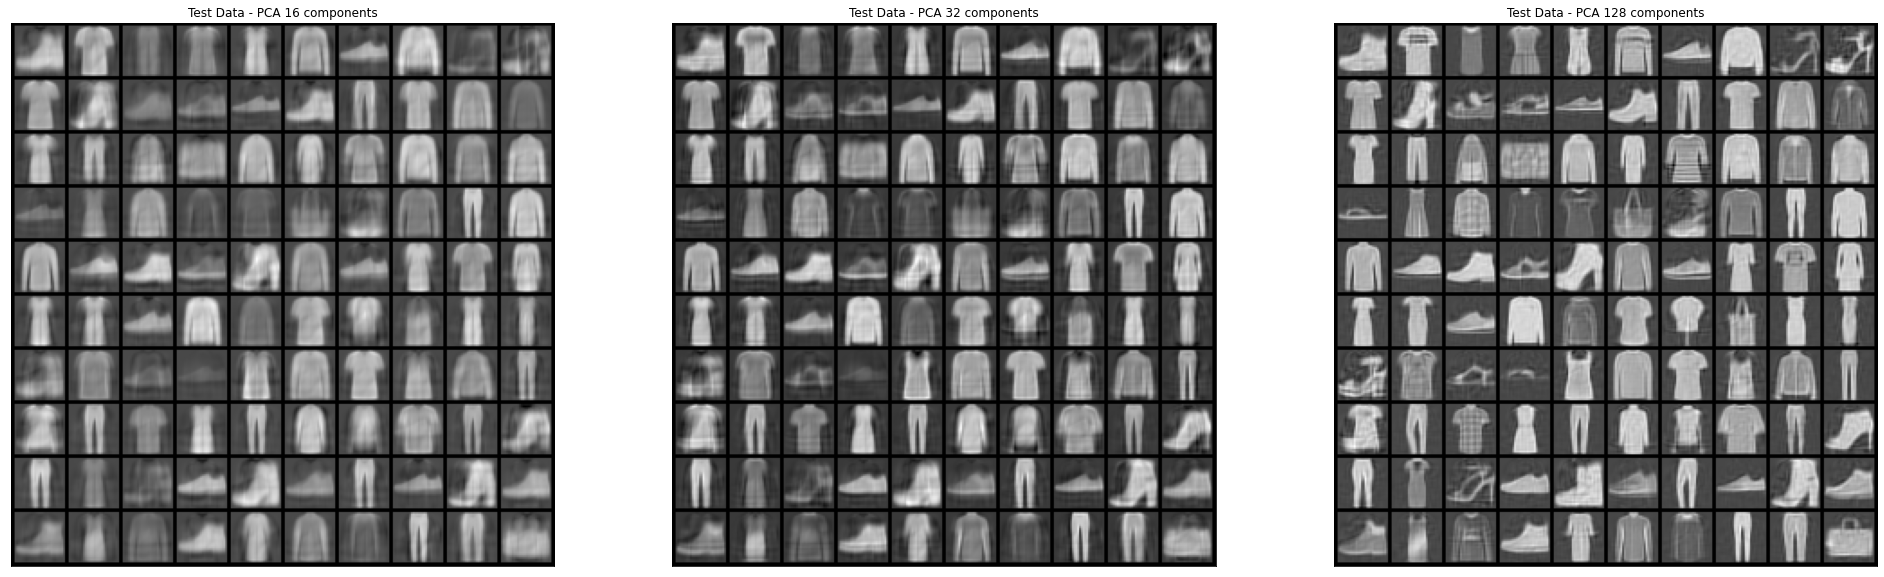

In [12]:
fig, axs = plt.subplots(1,3)
fig.set_figheight(10)
fig.set_figwidth(35)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

plot_images(rec16.view(100,1,28,28), 10, 10, "Test Data - PCA 16 components", fig, axs[0])
plot_images(rec32.view(100,1,28,28), 10, 10, "Test Data - PCA 32 components", fig, axs[1])
plot_images(rec128.view(100,1,28,28), 10, 10, "Test Data - PCA 128 components", fig, axs[2])

## Problem 3 - Conclusion
Qualitatively compared to the autoencoders, I can see the following differences:
1. The background of all reconstructed images using PCA are blurry.
2. For the 16 and 32 first components of PCA, the reconstructed images are worse than the ones produced by the autoencoders of 16 and 32 dimension latent space. It can be seen for some PCA reconstructed images that the edges of different clothes appear in the background, e.g. there is a sneaker, and behind it you can see the shape of a pullover as a shadow.
3. Besides the blurry background, the reconstructed images by PCA using the first 128 components look good. They can be compared with the images reconstructed by the convolutional autoencoder, since in both cases images are sharp and recover great part of the details.

Both PCA and autoencoders are able to map a high dimensional manifold (784 dimensions), where the original images lie, into a lower dimensional manifold (either 16,32 or 128 dimensions) and then reconstruct/map it again to the original higher dimensional manifold. However since PCA applies a linear mapping, it learns a linear manifold and some of the information about the images is not completely encoded when proyecting the images to the lower dimensional manifold. In contrast, autoencoders can have non-linear activation functions (sigmoid, elu, etc.) in their neurons, meaning that the mapping is done using non-linear functions, and thus they learn a non-linear manifold. Consequently, autoencoders can capture more information of the original images when proyecting the data to a lower dimensional manifold. In other words, using non-linear functions allow us to encode/decode images from a high dimensional manifold to lower dimensional manifold in a better way, and that explains why the reconstructed images with the autoencoders are higher quality than the ones reconstructed by PCA.

# Problem 4

In [13]:
def get_images_between(img1, img2, amountImg):
    """ img1 and img2 must be flattened """
    images = torch.zeros(amountImg, img1.shape[0])
    for p in range(img1.shape[0]):
        d = img2[p] - img1[p]
        increment = d / amountImg
        for i in range(amountImg):
            images[i][p] = img1[p] + i * increment
    return images

In [14]:
def get_representations_between(r1, r2, amountR):
    """ r1 and r2 must be flattened """
    representations = torch.zeros(amountR, r1.shape[0])
    for val in range(r1.shape[0]):
        d = r2[val] - r1[val]
        increment = d / amountR
        for r_n in range(amountR):
            representations[r_n][val] = r1[val] + r_n * increment
    return representations

## Images visually different

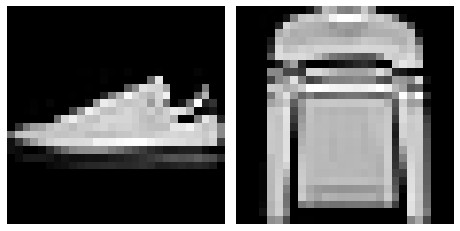

In [15]:
fig, axs = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(8)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

sneaker = first_batch_test[0][6].view(28,28)
pullover = first_batch_test[0][5].view(28,28)

axs[0].imshow(sneaker, cmap='gray')
axs[1].imshow(pullover, cmap='gray')
for i in range(2):
    axs[i].axis('off');

Sequence of images that are along the linear path


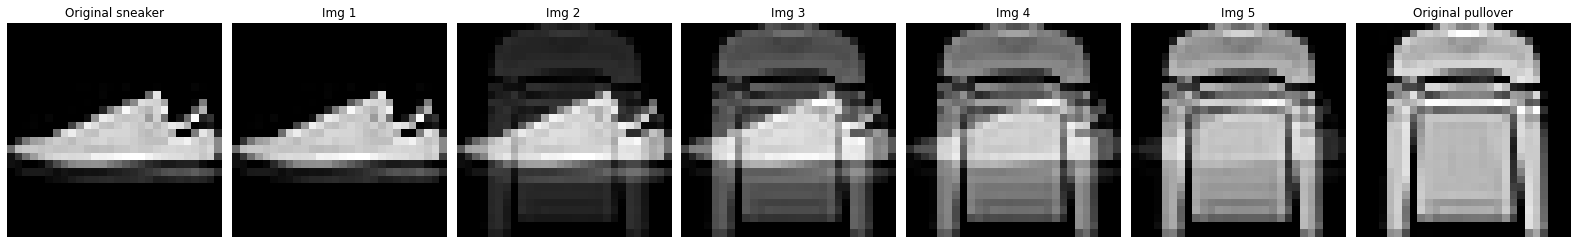

In [16]:
fig, axs = plt.subplots(1,7)
fig.set_figheight(4)
fig.set_figwidth(28)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

print("Sequence of images that are along the linear path")

images = get_representations_between(sneaker.view(-1), pullover.view(-1), 5)

axs[0].imshow(sneaker, cmap='gray')
axs[0].set_title('Original sneaker')

for i in range(1,6):
    axs[i].imshow(images[i-1].view(28,28), cmap='gray')
    axs[i].set_title('Img ' + str(i))

axs[6].imshow(pullover, cmap='gray')
axs[6].set_title('Original pullover')

for i in range(7):
    axs[i].axis('off');

Sequence of images that are interpolated in the latent code space of convolutional autoencoders


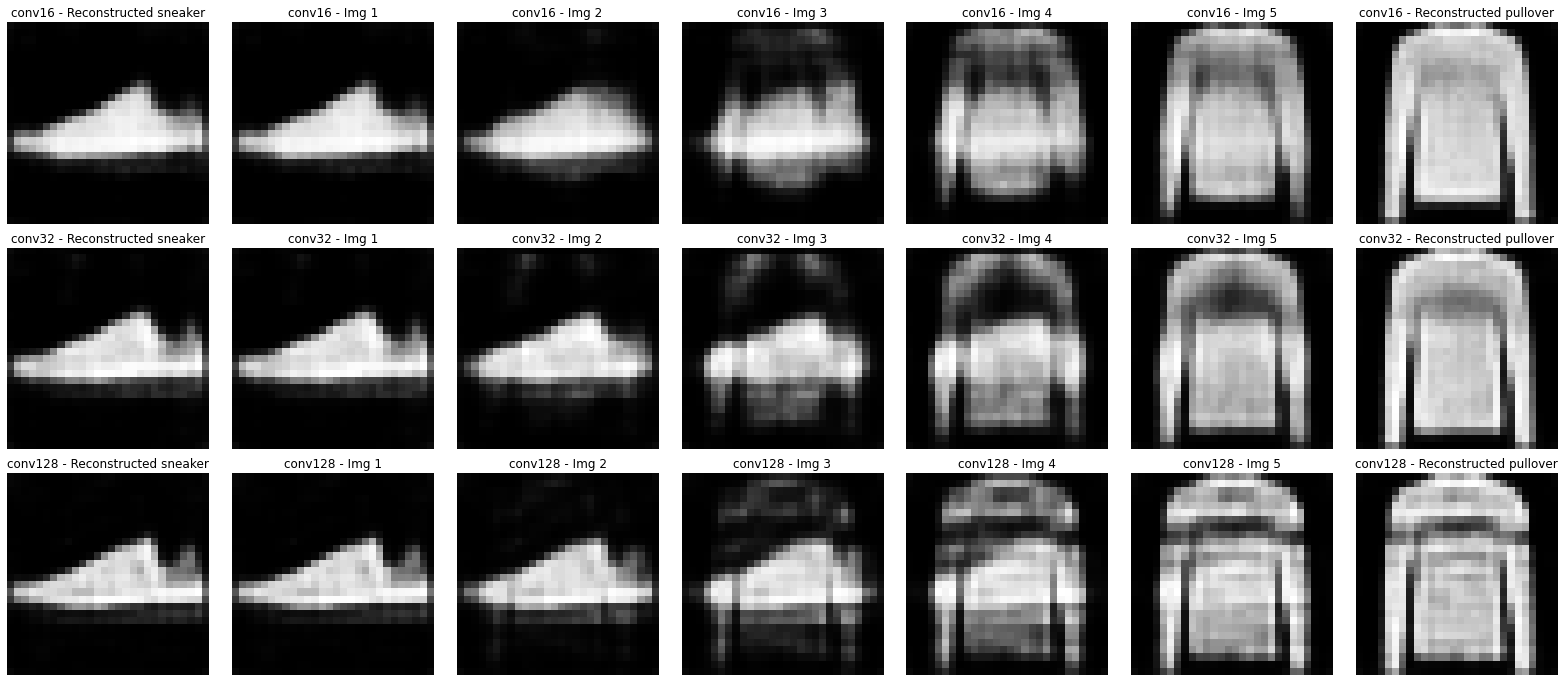

In [17]:
fig, axs = plt.subplots(3,7)
fig.set_figheight(12)
fig.set_figwidth(28)
plt.subplots_adjust(wspace=0.05, hspace=0.12)

print("Sequence of images that are interpolated in the latent code space of convolutional autoencoders")

aes = [convAE16,convAE32,convAE128]
for i,ae in enumerate([16,32,128]):
    sneakerEncoding = aes[i].encoder(sneaker.view(1,1,28,28))
    pulloverEncoding = aes[i].encoder(pullover.view(1,1,28,28))
    encodings = get_representations_between(sneakerEncoding.view(-1), pulloverEncoding.view(-1), 5)

    r_sneaker = aes[i].decoder(sneakerEncoding).detach()
    axs[i,0].imshow(r_sneaker.view(28,28), cmap='gray')
    axs[i,0].set_title(f'conv{ae}' + ' - Reconstructed sneaker')

    for img in range(1,6):
        reconstructed_img = aes[i].decoder(encodings[img-1].view(1,ae,1,1)).detach()
        axs[i,img].imshow(reconstructed_img.view(28,28), cmap='gray')
        axs[i,img].set_title(f'conv{ae}' + ' - Img ' + str(img))

    r_pullover = aes[i].decoder(pulloverEncoding).detach()
    axs[i,6].imshow(r_pullover.view(28,28), cmap='gray')
    axs[i,6].set_title(f'conv{ae}' + ' - Reconstructed pullover')

    for img in range(7):
        axs[i,img].axis('off');

Sequence of images that are interpolated in the latent code space of fully-connected autoencoders


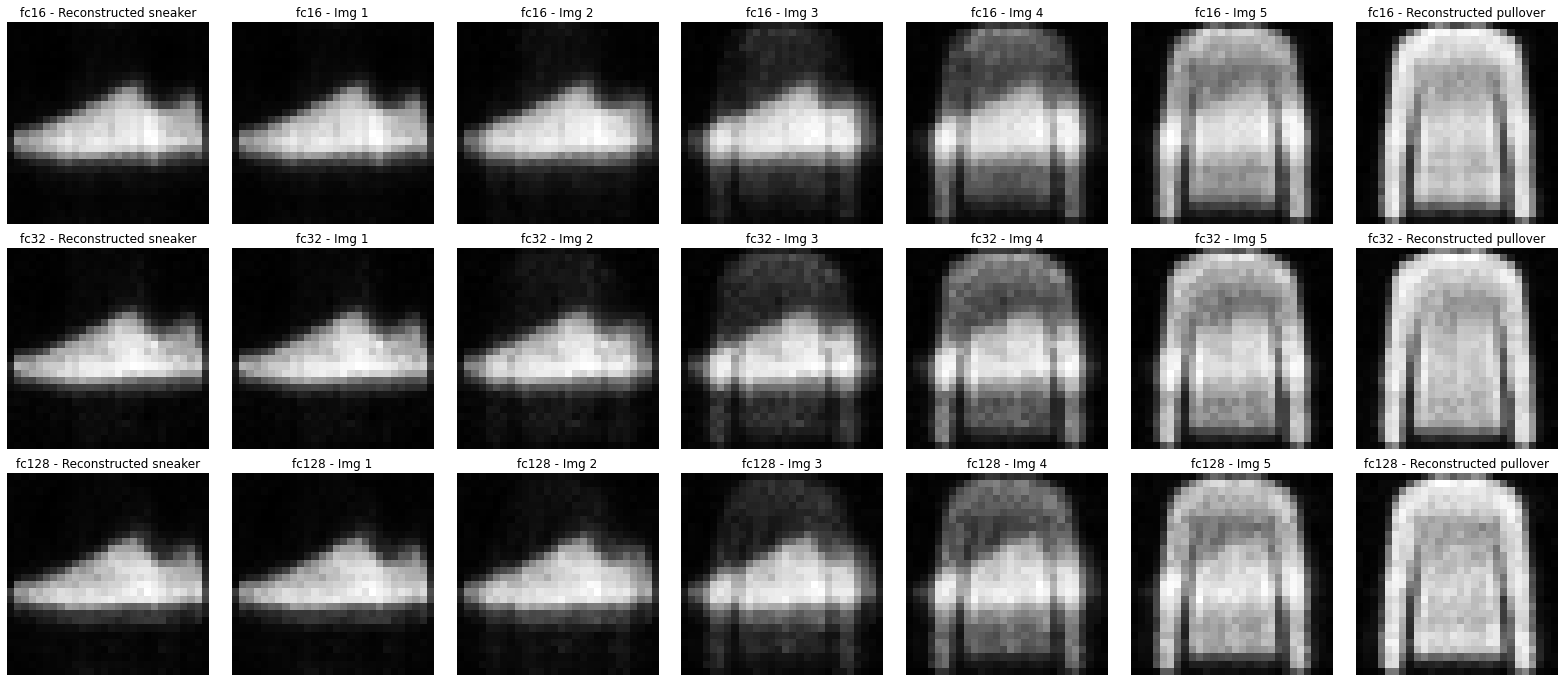

In [18]:
fig, axs = plt.subplots(3,7)
fig.set_figheight(12)
fig.set_figwidth(28)
plt.subplots_adjust(wspace=0.05, hspace=0.12)

print("Sequence of images that are interpolated in the latent code space of fully-connected autoencoders")

aes = [fcAE16,fcAE32,fcAE128]
for i,ae in enumerate([16,32,128]):
    sneakerEncoding = aes[i].encoder(sneaker.view(1,784))
    pulloverEncoding = aes[i].encoder(pullover.view(1,784))
    encodings = get_representations_between(sneakerEncoding.view(-1), pulloverEncoding.view(-1), 5)

    r_sneaker = aes[i].decoder(sneakerEncoding).detach()
    axs[i,0].imshow(r_sneaker.view(28,28), cmap='gray')
    axs[i,0].set_title(f'fc{ae}'+' - Reconstructed sneaker')

    for img in range(1,6):
        reconstructed_img = aes[i].decoder(encodings[img-1].view(1,ae)).detach()
        axs[i,img].imshow(reconstructed_img.view(28,28), cmap='gray')
        axs[i,img].set_title(f'fc{ae}'+' - Img ' + str(img))

    r_pullover = aes[i].decoder(pulloverEncoding).detach()
    axs[i,6].imshow(r_pullover.view(28,28), cmap='gray')
    axs[i,6].set_title(f'fc{ae}'+' - Reconstructed pullover')

    for img in range(7):
        axs[i,img].axis('off');

### Conclusion images visually different
For images that are visually different (sneaker and pullover), the sequence of images along the linear path do not seem to move from one class to the other in a smooth way, the images in between the two original images are just a combination of both objects. Instead for both autoencoder types, although they are not perfect, it can be seen that the images in between the two extremes of the sequence mutate in a smoother way. We can see that from the sneaker as the principal object in the image, the pullover starts to appear little by little, until it becames the main object in the image with the sneaker hidden in the center of it.

## Images visually similar

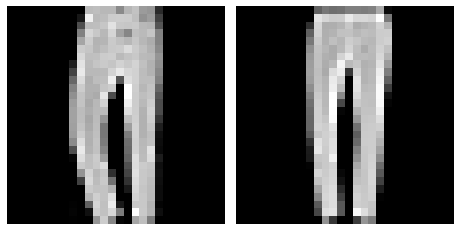

In [19]:
fig, axs = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(8)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

pant1 = first_batch_test[0][71].view(28,28)
pant2 = first_batch_test[0][74].view(28,28)

axs[0].imshow(pant1, cmap='gray')
axs[1].imshow(pant2, cmap='gray')
for i in range(2):
    axs[i].axis('off');

Sequence of images that are along the linear path


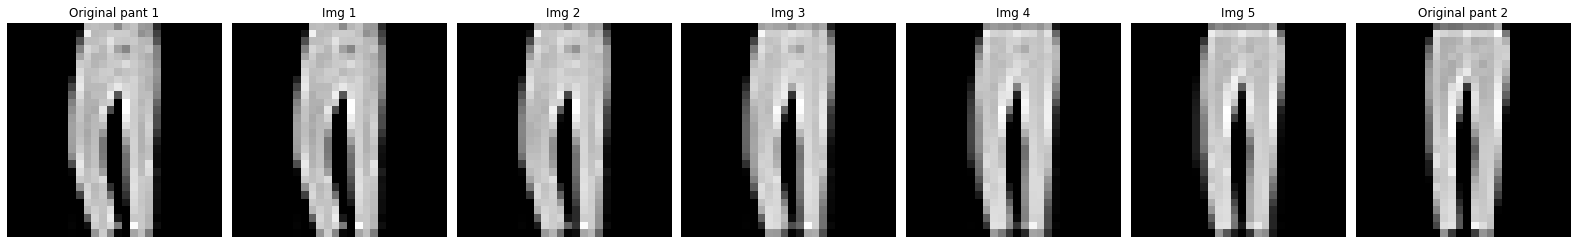

In [20]:
fig, axs = plt.subplots(1,7)
fig.set_figheight(4)
fig.set_figwidth(28)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

print("Sequence of images that are along the linear path")

images = get_representations_between(pant1.view(-1), pant2.view(-1), 5)

axs[0].imshow(pant1, cmap='gray')
axs[0].set_title('Original pant 1')

for i in range(1,6):
    axs[i].imshow(images[i-1].view(28,28), cmap='gray')
    axs[i].set_title('Img ' + str(i))

axs[6].imshow(pant2, cmap='gray')
axs[6].set_title('Original pant 2')

for i in range(7):
    axs[i].axis('off');

Sequence of images that are interpolated in the latent code space of convolutional autoencoders


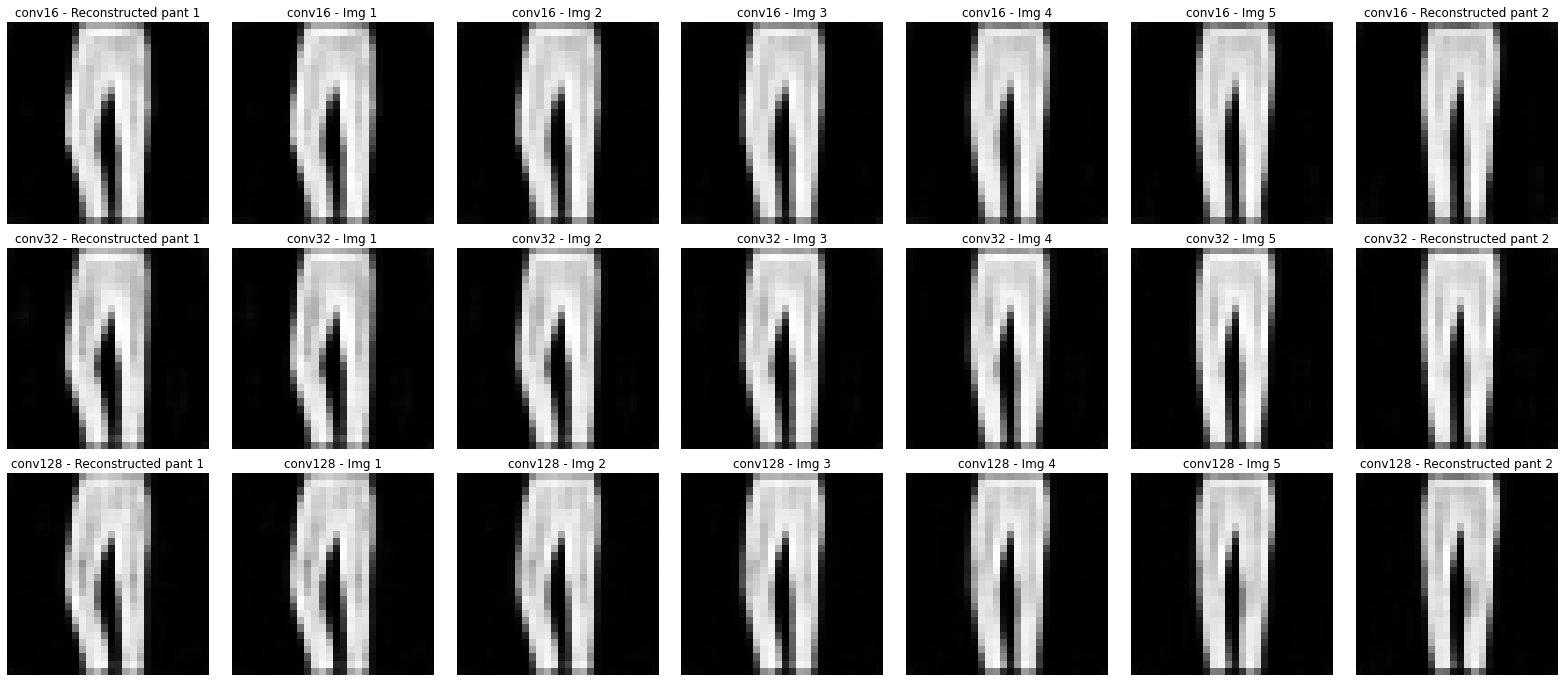

In [21]:
fig, axs = plt.subplots(3,7)
fig.set_figheight(12)
fig.set_figwidth(28)
plt.subplots_adjust(wspace=0.05, hspace=0.12)

print("Sequence of images that are interpolated in the latent code space of convolutional autoencoders")

aes = [convAE16,convAE32,convAE128]
for i,ae in enumerate([16,32,128]):
    pant1Encoding = aes[i].encoder(pant1.view(1,1,28,28))
    pant2Encoding = aes[i].encoder(pant2.view(1,1,28,28))
    encodings = get_representations_between(pant1Encoding.view(-1), pant2Encoding.view(-1), 5)

    r_pant1 = aes[i].decoder(pant1Encoding).detach()
    axs[i,0].imshow(r_pant1.view(28,28), cmap='gray')
    axs[i,0].set_title(f'conv{ae}' + ' - Reconstructed pant 1')

    for img in range(1,6):
        reconstructed_img = aes[i].decoder(encodings[img-1].view(1,ae,1,1)).detach()
        axs[i,img].imshow(reconstructed_img.view(28,28), cmap='gray')
        axs[i,img].set_title(f'conv{ae}' + ' - Img ' + str(img))

    r_pant2 = aes[i].decoder(pant2Encoding).detach()
    axs[i,6].imshow(r_pant2.view(28,28), cmap='gray')
    axs[i,6].set_title(f'conv{ae}' + ' - Reconstructed pant 2')

    for img in range(7):
        axs[i,img].axis('off');

Sequence of images that are interpolated in the latent code space of fully-connected autoencoders


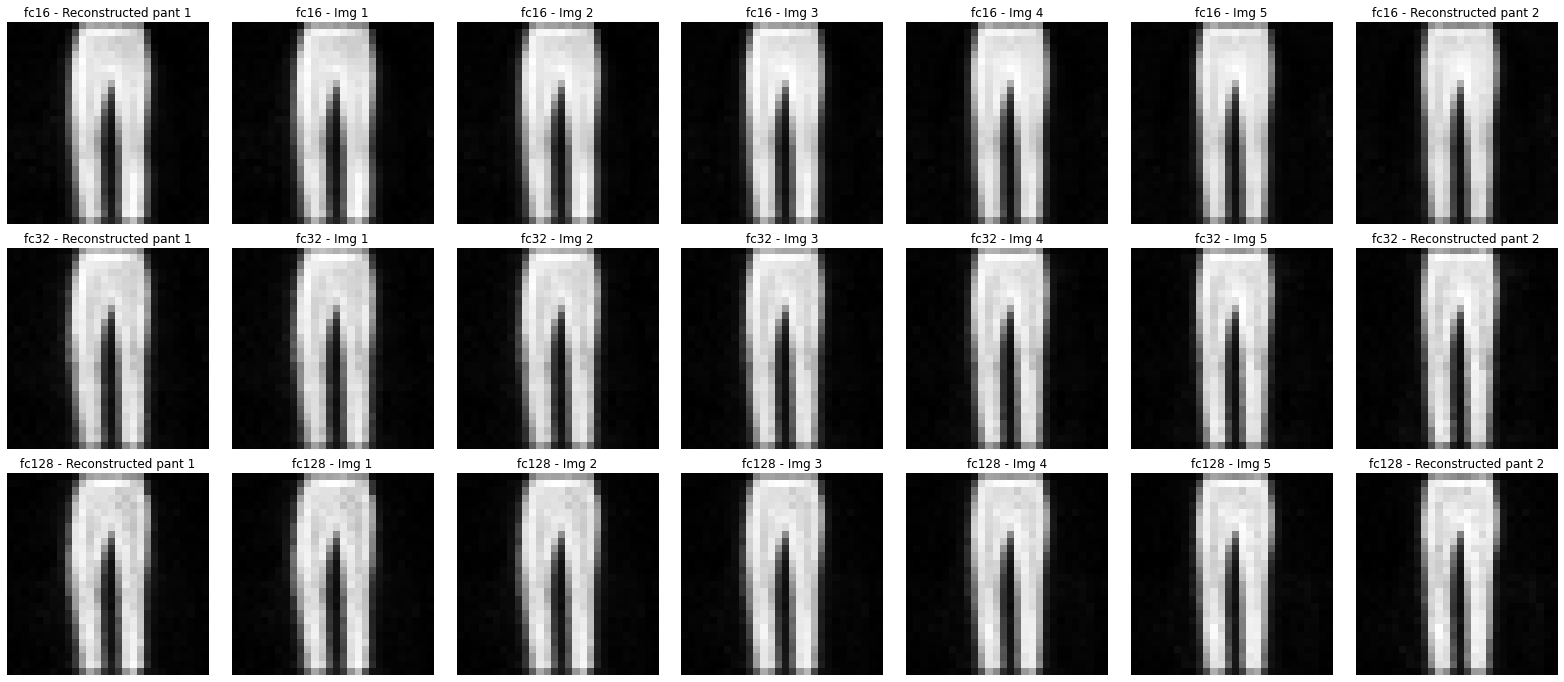

In [22]:
fig, axs = plt.subplots(3,7)
fig.set_figheight(12)
fig.set_figwidth(28)
plt.subplots_adjust(wspace=0.05, hspace=0.12)

print("Sequence of images that are interpolated in the latent code space of fully-connected autoencoders")

aes = [fcAE16,fcAE32,fcAE128]
for i,ae in enumerate([16,32,128]):
    pant1Encoding = aes[i].encoder(pant1.view(1,784))
    pant2Encoding = aes[i].encoder(pant2.view(1,784))
    encodings = get_representations_between(pant1Encoding.view(-1), pant2Encoding.view(-1), 5)

    r_pant1 = aes[i].decoder(pant1Encoding).detach()
    axs[i,0].imshow(r_pant1.view(28,28), cmap='gray')
    axs[i,0].set_title(f'fc{ae}'+' - Reconstructed pant 1')

    for img in range(1,6):
        reconstructed_img = aes[i].decoder(encodings[img-1].view(1,ae)).detach()
        axs[i,img].imshow(reconstructed_img.view(28,28), cmap='gray')
        axs[i,img].set_title(f'fc{ae}'+' - Img ' + str(img))

    r_pant2 = aes[i].decoder(pant2Encoding).detach()
    axs[i,6].imshow(r_pant2.view(28,28), cmap='gray')
    axs[i,6].set_title(f'fc{ae}'+' - Reconstructed pant 2')

    for img in range(7):
        axs[i,img].axis('off');

### Conclusion images visually similar
For images that are visually similar (two images of pants), the sequence of images along the linear path change in a very smooth way, the curvature of one of the legs of the pant decrease with each image in the secuence until it becames the second pant with both legs straight.

The behaviour for the sequence of images interpolated in the different latent space sizes is analogous to the one along the linear path. The only difference that I can tell is between the fully connected autoencoders and the convolutional autoencoders. It seems that the curvature of the first pant is being captured correctly by the convolutional models, but not very well by the fully connected models. I am not saying that the curvature is not being capture at all, but it is not as sharp and big as the original image nor the reconstruction made by the convolutional autoencoder. Therefore, the changes in the sequence of images from pant 1 to pant 2 for the fully connected model is more difficult to see.

# Problem 5
**NOTE:** For describing the output of each layer, I used a library called "summary" that outputs the output shape of each layer, in that way, you can calculate how many neurons a convolutional layer have. This library is going to be installed by executing the following cell.

In [23]:
!pip install torchsummary

In [24]:
def get_layers_rank(ae):
    for layer in ae.children():
        if isinstance(layer, nn.Linear):
            rank = torch.linalg.matrix_rank(layer.weight)
            print(f"{rank}")

## Fully-connected

### fcAE16

In [25]:
model = fcAE16.to(device)
summary(model, (1,784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
       BatchNorm1d-2                  [-1, 256]             512
            Linear-3                  [-1, 128]          32,896
       BatchNorm1d-4                  [-1, 128]             256
            Linear-5                   [-1, 16]           2,064
            Linear-6                  [-1, 128]           2,176
       BatchNorm1d-7                  [-1, 128]             256
            Linear-8                  [-1, 256]          33,024
       BatchNorm1d-9                  [-1, 256]             512
           Linear-10                  [-1, 784]         201,488
Total params: 474,144
Trainable params: 474,144
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.81
Estimated T

In [26]:
print("fcAE16 linear layers rank:")
get_layers_rank(fcAE16)

fcAE16 linear layers rank:
256
128
16
16
128
256


#### a)
$\mathbb{R}^{784} \to \mathbb{R}^{256} \to \mathbb{R}^{256} \to \mathbb{R}^{128} \to \mathbb{R}^{128} \to \mathbb{R}^{16} \to \mathbb{R}^{128} \to \mathbb{R}^{128} \to \mathbb{R}^{256} \to \mathbb{R}^{256} \to \mathbb{R}^{784}$

#### b)
Yes, it can be determined that the encoder is a **submersion** from the weights because:
- each layer in the encoder takes you to a progresively lower/equal dimension
- the weight matrix of each linear layer in the encoder is full rank. Note that the "BatchNorm1d" layer is full rank by definition, because it is just normalizing the weights.

#### c)
Yes, it can be determined that the decoder is a **immersion** from the weights because:
- each layer in the decoder takes you to a progresively higher/equal dimension
- the weight matrix of each linear layer in the decoder is full rank. Note that the "BatchNorm1d" layer is full rank by definition, because it is just normalizing the weights.

### fcAE32

In [27]:
model = fcAE32.to(device)
summary(model, (1,784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
       BatchNorm1d-2                  [-1, 256]             512
            Linear-3                  [-1, 128]          32,896
       BatchNorm1d-4                  [-1, 128]             256
            Linear-5                   [-1, 32]           4,128
            Linear-6                  [-1, 128]           4,224
       BatchNorm1d-7                  [-1, 128]             256
            Linear-8                  [-1, 256]          33,024
       BatchNorm1d-9                  [-1, 256]             512
           Linear-10                  [-1, 784]         201,488
Total params: 478,256
Trainable params: 478,256
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.82
Estimated T

In [28]:
print("fcAE32 linear layers rank:")
get_layers_rank(fcAE32)

fcAE32 linear layers rank:
256
128
32
32
128
256


#### a)
$\mathbb{R}^{784} \to \mathbb{R}^{256} \to \mathbb{R}^{256} \to \mathbb{R}^{128} \to \mathbb{R}^{128} \to \mathbb{R}^{32} \to \mathbb{R}^{128} \to \mathbb{R}^{128} \to \mathbb{R}^{256} \to \mathbb{R}^{256} \to \mathbb{R}^{784}$

#### b)
Yes, it can be determined that the encoder is a **submersion** from the weights because:
- each layer in the encoder takes you to a progresively lower/equal dimension
- the weight matrix of each linear layer in the encoder is full rank. Note that the "BatchNorm1d" layer is full rank by definition, because it is just normalizing the weights.

#### c)
Yes, it can be determined that the decoder is a **immersion** from the weights because:
- each layer in the decoder takes you to a progresively higher/equal dimension
- the weight matrix of each linear layer in the decoder is full rank. Note that the "BatchNorm1d" layer is full rank by definition, because it is just normalizing the weights.

### fcAE128

In [29]:
model = fcAE128.to(device)
summary(model, (1,784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
       BatchNorm1d-2                  [-1, 256]             512
            Linear-3                  [-1, 128]          32,896
       BatchNorm1d-4                  [-1, 128]             256
            Linear-5                  [-1, 128]          16,512
            Linear-6                  [-1, 128]          16,512
       BatchNorm1d-7                  [-1, 128]             256
            Linear-8                  [-1, 256]          33,024
       BatchNorm1d-9                  [-1, 256]             512
           Linear-10                  [-1, 784]         201,488
Total params: 502,928
Trainable params: 502,928
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.92
Estimated T

In [30]:
print("fcAE128 linear layers rank:")
get_layers_rank(fcAE128)

fcAE128 linear layers rank:
256
128
128
128
128
256


#### a)
$\mathbb{R}^{784} \to \mathbb{R}^{256} \to \mathbb{R}^{256} \to \mathbb{R}^{128} \to \mathbb{R}^{128} \to \mathbb{R}^{128} \to \mathbb{R}^{128} \to \mathbb{R}^{128} \to \mathbb{R}^{256} \to \mathbb{R}^{256} \to \mathbb{R}^{784}$

#### b)
Yes, it can be determined that the encoder is a **submersion** from the weights because:
- each layer in the encoder takes you to a progresively lower/equal dimension
- the weight matrix of each linear layer in the encoder is full rank. Note that the "BatchNorm1d" layer is full rank by definition, because it is just normalizing the weights.

#### c)
Yes, it can be determined that the decoder is a **immersion** from the weights because:
- each layer in the decoder takes you to a progresively higher/equal dimension
- the weight matrix of each linear layer in the decoder is full rank. Note that the "BatchNorm1d" layer is full rank by definition, because it is just normalizing the weights.

## Convolutional

### convAE16

In [31]:
model = convAE16.to(device)
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             800
       BatchNorm2d-2           [-1, 32, 24, 24]              64
            Conv2d-3            [-1, 8, 20, 20]           6,400
       BatchNorm2d-4            [-1, 8, 20, 20]              16
            Conv2d-5             [-1, 16, 1, 1]          51,216
   ConvTranspose2d-6            [-1, 8, 20, 20]          51,208
       BatchNorm2d-7            [-1, 8, 20, 20]              16
   ConvTranspose2d-8           [-1, 32, 24, 24]           6,400
       BatchNorm2d-9           [-1, 32, 24, 24]              64
  ConvTranspose2d-10            [-1, 1, 28, 28]             800
Total params: 116,984
Trainable params: 116,984
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 0.45
Estimated T

#### a)
$\mathbb{R}^{784} \to \mathbb{R}^{18432} \to \mathbb{R}^{18432} \to \mathbb{R}^{4608} \to \mathbb{R}^{4608} \to \mathbb{R}^{16} \to \mathbb{R}^{4608} \to \mathbb{R}^{4608} \to \mathbb{R}^{18432} \to \mathbb{R}^{18432} \to \mathbb{R}^{784}$

#### b)
No, it cannot be determined that the encoder is a **submersion** from the weights because:
- each layer in the encoder does not take you to a progresively lower/equal dimension. The input layer of the encoder has 784 neurons and the first convolutional layer in the encoder has 18432 neurons, therefore the property is broken.

#### c)
No, it cannot be determined that the encoder is a **immersion** from the weights because:
- each layer in the decoder does not take you to a progresively higher/equal dimension. The last convolutional layer in the decoder has 18432 neurons and the output layer of the decoder has 784 neurons, therefore the property is broken.

### convAE32

In [32]:
model = convAE32.to(device)
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             800
       BatchNorm2d-2           [-1, 32, 24, 24]              64
            Conv2d-3            [-1, 8, 20, 20]           6,400
       BatchNorm2d-4            [-1, 8, 20, 20]              16
            Conv2d-5             [-1, 32, 1, 1]         102,432
   ConvTranspose2d-6            [-1, 8, 20, 20]         102,408
       BatchNorm2d-7            [-1, 8, 20, 20]              16
   ConvTranspose2d-8           [-1, 32, 24, 24]           6,400
       BatchNorm2d-9           [-1, 32, 24, 24]              64
  ConvTranspose2d-10            [-1, 1, 28, 28]             800
Total params: 219,400
Trainable params: 219,400
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 0.84
Estimated T

#### a)
$\mathbb{R}^{784} \to \mathbb{R}^{18432} \to \mathbb{R}^{18432} \to \mathbb{R}^{4608} \to \mathbb{R}^{4608} \to \mathbb{R}^{32} \to \mathbb{R}^{4608} \to \mathbb{R}^{4608} \to \mathbb{R}^{18432} \to \mathbb{R}^{18432} \to \mathbb{R}^{784}$

#### b)
No, it cannot be determined that the encoder is a **submersion** from the weights because:
- each layer in the encoder does not take you to a progresively lower/equal dimension. The input layer of the encoder has 784 neurons and the first convolutional layer in the encoder has 18432 neurons, therefore the property is broken.

#### c)
No, it cannot be determined that the encoder is a **immersion** from the weights because:
- each layer in the decoder does not take you to a progresively higher/equal dimension. The last convolutional layer in the decoder has 18432 neurons and the output layer of the decoder has 784 neurons, therefore the property is broken.

### convAE128

In [33]:
model = convAE128.to(device)
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             800
       BatchNorm2d-2           [-1, 32, 24, 24]              64
            Conv2d-3            [-1, 8, 20, 20]           6,400
       BatchNorm2d-4            [-1, 8, 20, 20]              16
            Conv2d-5            [-1, 128, 1, 1]         409,728
   ConvTranspose2d-6            [-1, 8, 20, 20]         409,608
       BatchNorm2d-7            [-1, 8, 20, 20]              16
   ConvTranspose2d-8           [-1, 32, 24, 24]           6,400
       BatchNorm2d-9           [-1, 32, 24, 24]              64
  ConvTranspose2d-10            [-1, 1, 28, 28]             800
Total params: 833,896
Trainable params: 833,896
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 3.18
Estimated T

#### a)
$\mathbb{R}^{784} \to \mathbb{R}^{18432} \to \mathbb{R}^{18432} \to \mathbb{R}^{4608} \to \mathbb{R}^{4608} \to \mathbb{R}^{128} \to \mathbb{R}^{4608} \to \mathbb{R}^{4608} \to \mathbb{R}^{18432} \to \mathbb{R}^{18432} \to \mathbb{R}^{784}$

#### b)
No, it cannot be determined that the encoder is a **submersion** from the weights because:
- each layer in the encoder does not take you to a progresively lower/equal dimension. The input layer of the encoder has 784 neurons and the first convolutional layer in the encoder has 18432 neurons, therefore the property is broken.

#### c)
No, it cannot be determined that the encoder is a **immersion** from the weights because:
- each layer in the decoder does not take you to a progresively higher/equal dimension. The last convolutional layer in the decoder has 18432 neurons and the output layer of the decoder has 784 neurons, therefore the property is broken.

# Problem 6

In [34]:
def get_decoder_jacobian(img, ae, ls, device):
    img = img.to(device)
    encoded_img = ae.encoder(img)
    J = torch.autograd.functional.jacobian(ae.decoder, encoded_img)
    J = J.view(784,ls)
    return J.to('cpu')

In [35]:
aes_names = ['conv16','conv32','conv128','fc16','fc32','fc128']
aes_ls = [16,32,128,16,32,128]
aes = [convAE16,convAE32,convAE128,fcAE16,fcAE32,fcAE128]
Jacobians = {}
for i,(name,ae) in enumerate(zip(aes_names,aes)):
    if name.startswith('conv'):
        img = pullover.view(1,1,28,28)
    else:
        img = pullover.view(1,784)
    
    Jacobians[name] = get_decoder_jacobian(img, ae, aes_ls[i], device)
    eigenvectors, eigenvalues, _ = linalg.svd(Jacobians[name])

    print(name + '\n')
    print(f"Max singular value: {max(eigenvalues)}")
    print(f"Min singular value: {min(eigenvalues)}")
    print(f"Rank: {np.linalg.matrix_rank(Jacobians[name])} / {aes_ls[i]}\n")


conv16

Max singular value: 8.667534828186035
Min singular value: 2.6686999797821045
Rank: 16 / 16

conv32

Max singular value: 6.934484004974365
Min singular value: 1.1016472578048706
Rank: 32 / 32

conv128

Max singular value: 8.368250846862793
Min singular value: 0.4046984016895294
Rank: 128 / 128

fc16

Max singular value: 14.19372272491455
Min singular value: 1.9886605739593506
Rank: 16 / 16

fc32

Max singular value: 11.16087818145752
Min singular value: 0.48035895824432373
Rank: 32 / 32

fc128

Max singular value: 8.959903717041016
Min singular value: 4.066716428496875e-06
Rank: 125 / 128



In [36]:
print("fcAE128 decoder max and min singular values:\n")
eigenvectors, eigenvalues, _ = linalg.svd(fcAE128.dlayer1.weight.cpu().detach().numpy())
print(f"Layer #1: \nmax singular value: {max(eigenvalues)}")
print(f"min singular value: {min(eigenvalues)}")
print(f"Rank: {torch.linalg.matrix_rank(fcAE128.dlayer1.weight)}\n")

eigenvectors, eigenvalues, _ = linalg.svd(fcAE128.dlayer2.weight.cpu().detach().numpy())
print(f"Layer #2: \nmax singular value: {max(eigenvalues)}")
print(f"min singular value: {min(eigenvalues)}")
print(f"Rank: {torch.linalg.matrix_rank(fcAE128.dlayer2.weight)}\n")

eigenvectors, eigenvalues, _ = linalg.svd(fcAE128.dlayer3.weight.cpu().detach().numpy())
print(f"Layer #3: \nmax singular value: {max(eigenvalues)}")
print(f"min singular value: {min(eigenvalues)}")
print(f"Rank: {torch.linalg.matrix_rank(fcAE128.dlayer3.weight)}")


fcAE128 decoder max and min singular values:

Layer #1: 
max singular value: 1.1238292455673218
min singular value: 0.0002852489415090531
Rank: 128

Layer #2: 
max singular value: 1.3716685771942139
min singular value: 0.2345971167087555
Rank: 128

Layer #3: 
max singular value: 7.728073596954346
min singular value: 0.4552966058254242
Rank: 256


## Problem 6 - Conclusion
It is very clear that for conv16, conv32, conv128, fc16 and fc32 the min singular value is greater than 0, meaning that the Jacobian is full rank and consequently showing that the decoder is an immersion. However for the fc128 autoencoder, the min singular value is 2.28x10^-6, a number very close to 0. Therefore, depending on how many decimal positions we use, this can mean that the jacobian is not full rank and thus the decoder is not an immersion.

If we take a closer look at the min and max singular values and the rank of each weight matrix for the fcAE128, we can see that all layers are full rank and the min singular values are not 0, indicating that the **fcAE128 decoder** should be an immersion, as indicated in problem 5. However, the min singular value for the first layer is 0.00028, which is low and very close to 0. Therefore when we make the composition of layers, we can expect that number to go down even further, and that could explain why our jacobian matrix for our base image is not full rank for this autoencoder version.

# Problem 7

Tangent vectors of ConvAE16


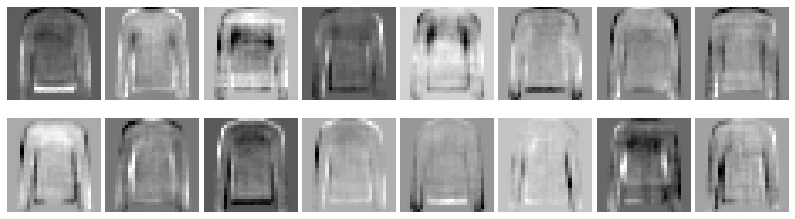

In [37]:
J_conv_16 = Jacobians['conv16']
print('Tangent vectors of ConvAE16')

fig, axs = plt.subplots(2,8)
fig.set_figheight(4)
fig.set_figwidth(14)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i in range(2):
    for j in range(8):
        axs[i,j].imshow(J_conv_16[:,i*8+j].view(28,28), cmap='gray')
        axs[i,j].axis('off')

Tangent vectors of ConvAE32


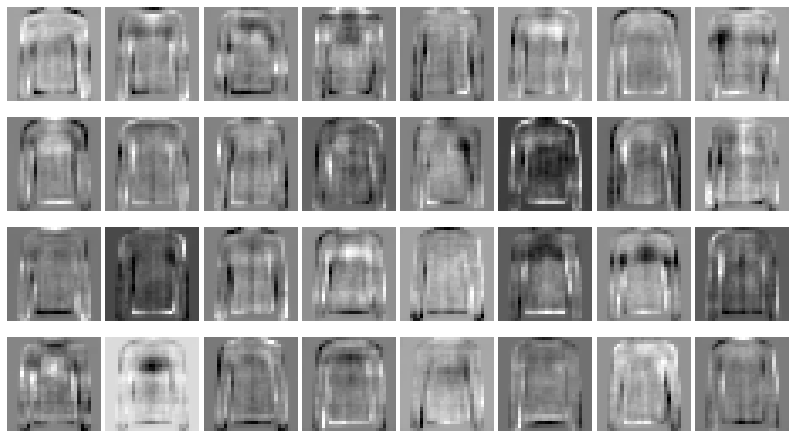

In [38]:
J_conv_32 = Jacobians['conv32']
print('Tangent vectors of ConvAE32')

fig, axs = plt.subplots(4,8)
fig.set_figheight(8)
fig.set_figwidth(14)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i in range(4):
    for j in range(8):
        axs[i,j].imshow(J_conv_32[:,i*8+j].view(28,28), cmap='gray')
        axs[i,j].axis('off')

Tangent vectors of ConvAE128


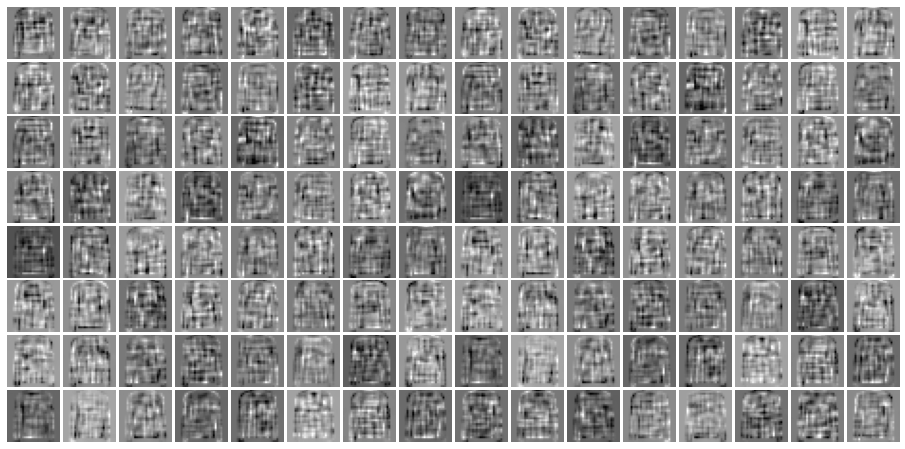

In [39]:
J_conv_128 = Jacobians['conv128']
print('Tangent vectors of ConvAE128')

fig, axs = plt.subplots(8,16)
fig.set_figheight(8)
fig.set_figwidth(16)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i in range(8):
    for j in range(16):
        axs[i,j].imshow(J_conv_128[:,i*8+j].view(28,28), cmap='gray')
        axs[i,j].axis('off')

Tangent vectors of fcAE16


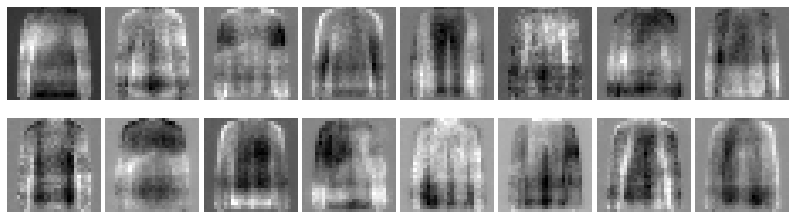

In [40]:
J_fc_16 = Jacobians['fc16']
print('Tangent vectors of fcAE16')

fig, axs = plt.subplots(2,8)
fig.set_figheight(4)
fig.set_figwidth(14)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i in range(2):
    for j in range(8):
        axs[i,j].imshow(J_fc_16[:,i*8+j].view(28,28), cmap='gray')
        axs[i,j].axis('off')

Tangent vectors of fcAE32


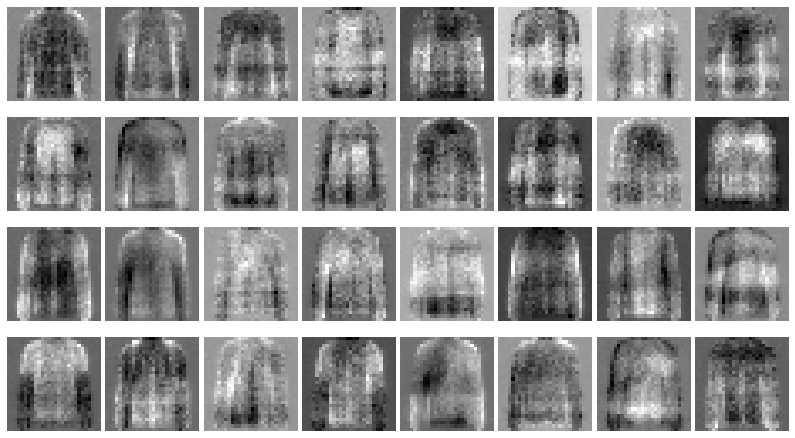

In [41]:
J_fc_32 = Jacobians['fc32']
print('Tangent vectors of fcAE32')

fig, axs = plt.subplots(4,8)
fig.set_figheight(8)
fig.set_figwidth(14)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i in range(4):
    for j in range(8):
        axs[i,j].imshow(J_fc_32[:,i*8+j].view(28,28), cmap='gray')
        axs[i,j].axis('off')

Tangent vectors of fcAE128


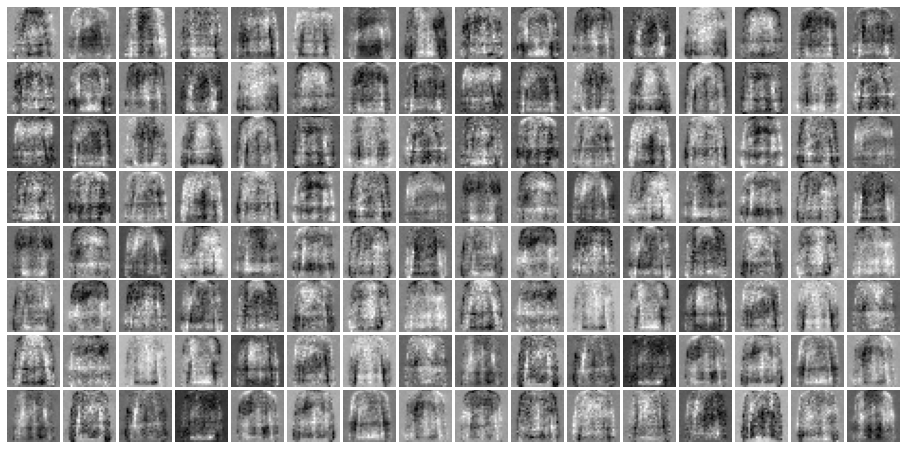

In [42]:
J_fc_128 = Jacobians['fc128']
print('Tangent vectors of fcAE128')

fig, axs = plt.subplots(8,16)
fig.set_figheight(8)
fig.set_figwidth(16)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i in range(8):
    for j in range(16):
        axs[i,j].imshow(J_fc_128[:,i*8+j].view(28,28), cmap='gray')
        axs[i,j].axis('off')

Tangent vectors of principal components


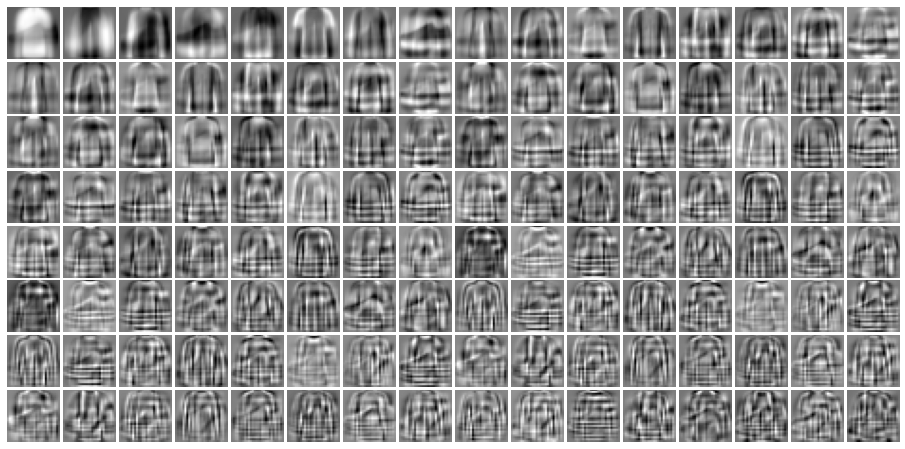

In [43]:
tv_pc = principal_components[:128,:]

print('Tangent vectors of principal components')

fig, axs = plt.subplots(8,16)
fig.set_figheight(8)
fig.set_figwidth(16)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i in range(8):
    for j in range(16):
        axs[i,j].imshow(tv_pc[i*8+j,:].reshape(28,28), cmap='gray')
        axs[i,j].axis('off')

## Problem 7 - Conclusion
By looking at the tangent vector of the different autoencoders versions, we can see that the overall trend is that with a bigger latent space size, we can encode/retain more information/characteristics of the images. The autoencoders with latent space of size 16 are able to encode the shape of the pullover in this case, by retaining the information of the edges of it. The autoencoders with latent space of size 32 start to encode some of the details of the pullover, like lines or any other design that can appear in them. Finally, the autoencoder of latent space of size 128 can encode much more details of the base image. If we see the 128 tangent vectors, we can see that they are pointing out different parts of the pullover that can change, though it is difficult to understand what particular feature each tangent vector is capturing.

On the other hand, the tangent vectors corresponding to the first 128 components of PCA, seems to contain the shade of multiple classes of clothes, rather than one class at a time, like the autoencoders do with a base image from a specific class. This makes sense, since the tangent vectors of PCA are the eigenvectors, which are not generated from a base image, but from the entire set of training images. Consequently, these tangent vectors capture the entire variance between all the classes in the dataset.

# Problem 8

In [44]:
def project_onto_column_space(jacobian, fda):
    """ fda: finite difference approximation """
    coeficient = np.linalg.lstsq(jacobian, fda, rcond=None)[0]
    projection = jacobian @ coeficient
    return projection

## Original Pullover transformation plots

Rotate pullover


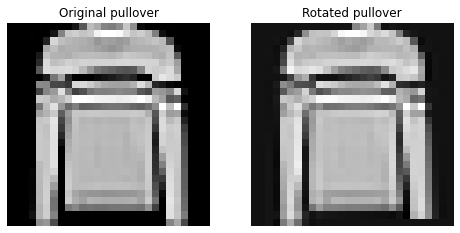

In [45]:
rotated_pullover = ndimage.rotate(pullover.view(28,28), 1, reshape=False)
rotation_derivative_p = rotated_pullover.reshape(784) - pullover.view(784).detach().numpy()

fig, axs = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(8)

print("Rotate pullover")
axs[0].imshow(pullover, cmap='gray')
axs[0].set_title("Original pullover")
axs[1].imshow(rotated_pullover, cmap='gray')
axs[1].set_title("Rotated pullover")

for i in range(2):
    axs[i].axis('off');

Shift pullover in X


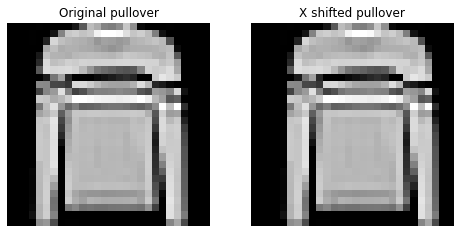

In [46]:
x_shifted_pullover = ndimage.shift(pullover, [0,1])
x_shifted_derivative_p = x_shifted_pullover.reshape(784) - pullover.view(784).detach().numpy()

fig, axs = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(8)

print("Shift pullover in X")
axs[0].imshow(pullover, cmap='gray')
axs[0].set_title("Original pullover")
axs[1].imshow(x_shifted_pullover, cmap='gray')
axs[1].set_title("X shifted pullover")

for i in range(2):
    axs[i].axis('off');

Shift pullover in Y


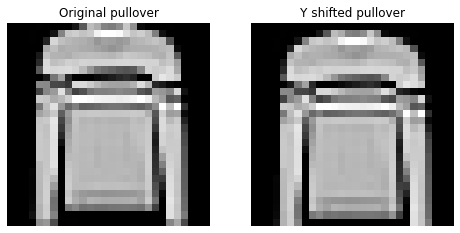

In [47]:
y_shifted_pullover = ndimage.shift(pullover, [1,0])
y_shifted_derivative_p = y_shifted_pullover.reshape(784) - pullover.view(784).detach().numpy()

fig, axs = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(8)

print("Shift pullover in Y")
axs[0].imshow(pullover, cmap='gray')
axs[0].set_title("Original pullover")
axs[1].imshow(y_shifted_pullover, cmap='gray')
axs[1].set_title("Y shifted pullover")

for i in range(2):
    axs[i].axis('off');

In [48]:
aes_names = ['conv16','conv32','conv128','fc16','fc32','fc128']
aes = [convAE16,convAE32,convAE128,fcAE16,fcAE32,fcAE128]
for i, name in enumerate(aes_names):
    print(name)
    
    if name.startswith('conv'):
        img = pullover.view(1,1,28,28).to(device)
    else:
        img = pullover.view(1,784).to(device)

    # Pass base image through autoencoder
    reconstructed_pullover = aes[i](img).cpu().detach()

    # Rotate reconstructed img
    aux_rotated_pullover = ndimage.rotate(reconstructed_pullover.view(28,28), 1, reshape=False)
    aux_rotation_derivative_p = aux_rotated_pullover.reshape(784) - reconstructed_pullover.view(784).detach().numpy()

    # Shift reconstructed img on X-axis
    aux_x_shifted_pullover = ndimage.shift(reconstructed_pullover.view(28,28), [0,1])
    aux_x_shifted_derivative_p = aux_x_shifted_pullover.reshape(784) - reconstructed_pullover.view(784).detach().numpy()

    # Shift reconstructed img on Y-axis
    aux_y_shifted_pullover = ndimage.shift(reconstructed_pullover.view(28,28), [1,0])
    aux_y_shifted_derivative_p = aux_y_shifted_pullover.reshape(784) - reconstructed_pullover.view(784).detach().numpy()

    rot_projection = project_onto_column_space(Jacobians[name], aux_rotation_derivative_p)
    rot_angle = np.arccos(np.dot(rot_projection, aux_rotation_derivative_p) / (np.linalg.norm(rot_projection) * np.linalg.norm(aux_rotation_derivative_p))) * 180 / np.pi
    print(f"Rotation transform angle: {rot_angle}")
    x_shift_projection = project_onto_column_space(Jacobians[name], aux_x_shifted_derivative_p)
    x_shift_angle = np.arccos(np.dot(x_shift_projection, aux_x_shifted_derivative_p) / (np.linalg.norm(x_shift_projection) * np.linalg.norm(aux_x_shifted_derivative_p))) * 180 / np.pi
    print(f"X shift transform angle: {x_shift_angle}")
    y_shift_projection = project_onto_column_space(Jacobians[name], aux_y_shifted_derivative_p)
    y_shift_angle = np.arccos(np.dot(y_shift_projection, aux_y_shifted_derivative_p) / (np.linalg.norm(y_shift_projection) * np.linalg.norm(aux_y_shifted_derivative_p))) * 180 / np.pi
    print(f"Y shift transform angle: {y_shift_angle}\n")

conv16
Rotation transform angle: 52.633475310158694
X shift transform angle: 39.081106166573186
Y shift transform angle: 36.54096222934003

conv32
Rotation transform angle: 51.747746623875194
X shift transform angle: 33.42267351471656
Y shift transform angle: 30.625048521246846

conv128
Rotation transform angle: 36.137595162621174
X shift transform angle: 22.513582457284112
Y shift transform angle: 21.60131677852782

fc16
Rotation transform angle: 69.28151841202576
X shift transform angle: 53.06854128481558
Y shift transform angle: 49.42797532511791

fc32
Rotation transform angle: 60.40792105745278
X shift transform angle: 42.462469862363456
Y shift transform angle: 41.6628971822705

fc128
Rotation transform angle: 49.09891047128504
X shift transform angle: 35.984564774267035
Y shift transform angle: 32.12304219491946



In [49]:
# Encoding
pullover_pca16 = pullover.view(-1) @ principal_components[:16,:].T # 1x784 @ 16x784.T = 1x16
pullover_pca32 = pullover.view(-1) @ principal_components[:32,:].T # 1x784 @ 32x784.T = 1x32
pullover_pca128 = pullover.view(-1) @ principal_components[:128,:].T # 1x784 @ 128x784.T = 1x128

# Reconstruction
pullover_rec16 = pullover_pca16 @ principal_components[:16,:] # 1x16 @ 16x784 = 1x784
pullover_rec32 = pullover_pca32 @ principal_components[:32,:] # 1x32 @ 32x784 = 1x784
pullover_rec128 = pullover_pca128 @ principal_components[:128,:] # 1x128 @ 128x784 = 1x784

reconstructed_pullovers = [pullover_rec16, pullover_rec32, pullover_rec128]

components = [16,32,128]
for i,c in enumerate(components):
    print(f"PCA {c} components")
    
    # Rotate reconstructed img
    aux_rotated_pullover = ndimage.rotate(reconstructed_pullovers[i].view(28,28), 1, reshape=False)
    aux_rotation_derivative_p = aux_rotated_pullover.reshape(784) - reconstructed_pullovers[i].view(784).detach().numpy()

    # Shift reconstructed img on X-axis
    aux_x_shifted_pullover = ndimage.shift(reconstructed_pullovers[i].view(28,28), [0,1])
    aux_x_shifted_derivative_p = aux_x_shifted_pullover.reshape(784) - reconstructed_pullovers[i].view(784).detach().numpy()

    # Shift reconstructed img on Y-axis
    aux_y_shifted_pullover = ndimage.shift(reconstructed_pullovers[i].view(28,28), [1,0])
    aux_y_shifted_derivative_p = aux_y_shifted_pullover.reshape(784) - reconstructed_pullovers[i].view(784).detach().numpy()

    rot_projection = project_onto_column_space(principal_components[:c,:].T, aux_rotation_derivative_p)
    rot_angle = np.arccos(np.dot(rot_projection, aux_rotation_derivative_p) / (np.linalg.norm(rot_projection) * np.linalg.norm(aux_rotation_derivative_p))) * 180 / np.pi
    print(f"Rotation transform angle: {rot_angle}")
    x_shift_projection = project_onto_column_space(principal_components[:c,:].T, aux_x_shifted_derivative_p)
    x_shift_angle = np.arccos(np.dot(x_shift_projection, aux_x_shifted_derivative_p) / (np.linalg.norm(x_shift_projection) * np.linalg.norm(aux_x_shifted_derivative_p))) * 180 / np.pi
    print(f"X shift transform angle: {x_shift_angle}")
    y_shift_projection = project_onto_column_space(principal_components[:c,:].T, aux_y_shifted_derivative_p)
    y_shift_angle = np.arccos(np.dot(y_shift_projection, aux_y_shifted_derivative_p) / (np.linalg.norm(y_shift_projection) * np.linalg.norm(aux_y_shifted_derivative_p))) * 180 / np.pi
    print(f"Y shift transform angle: {y_shift_angle}\n")

PCA 16 components
Rotation transform angle: 79.91265935021023
X shift transform angle: 53.24442082439134
Y shift transform angle: 43.26125340054072

PCA 32 components
Rotation transform angle: 64.12156872501187
X shift transform angle: 21.956761020878723
Y shift transform angle: 27.877249439731504

PCA 128 components
Rotation transform angle: 41.75315957862745
X shift transform angle: 13.390905124969658
Y shift transform angle: 12.480382373567544



Overall, for the autoencoders we can see that:
- For rotation, X-shift and Y-shift transformations, convolutional autoencoders do a better job than fully-connected models.
- Having a bigger latent space dimension, will make the angle between the tangent space and the translation or rotation vector smaller. Meaning that autoencoders with higher dimensional latent space are more invariant to rotations and translations.
- Although the angles between the tangent space and the translation or rotation vector are not 0, meaning that these autoencoders are not 100% invariant to these transformations, it is not completely normal either. This is something good because the autoencoders are being able, to some extent, to capture these variants of the reconstructed images, even though they were not trained to do that. In order to make autoencoders more robust to these types of transformations, we can augment our training set by adding rotation and translation to the images and then retrain the models.

On the other hand, for PCA we can see that:
- Using more principal components also makes the angle between the tangent space and the translation or rotation vector smaller. Thus making PCA more invariant to rotation and translation.
- Using 128 components, for the X-sift and Y-sift transformations, PCA has smaller angles than the convAE128 (most invariant autoencoder). I was pretty surprised of these results since I didn't expect PCA to do that well. Next I provide a possible explanation of why that may be happening. If we take a look at the plot of the first 128 tangent vectors of the PCA, we can see that the shape of a pullover/shirt/t-shirt (all very related shapes), are present in most, if not all, the tangent vectors. For some reason, PCA seems to encode these shapes particullarly well, thus we could expect this object to be invariant to some transformations because PCA is doing a great job in encoding it.

Next I am going to show the case for a sneaker, where the convolutional performs better for the X translation and rotation transformations.

## Original Sneaker transformation plots

In [50]:
### Calculate jacobian for sneaker
Jacobians_sneaker = {}
for i,(name,ae) in enumerate(zip(aes_names,aes)):
    if name.startswith('conv'):
        img = sneaker.view(1,1,28,28)
    else:
        img = sneaker.view(1,784)
    
    Jacobians_sneaker[name] = get_decoder_jacobian(img, ae, aes_ls[i], device)

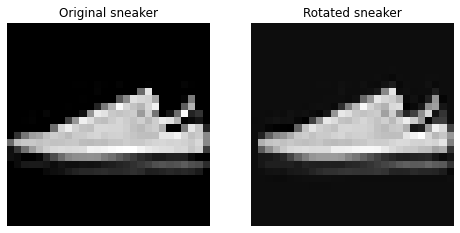

In [51]:
rotated_sneaker = ndimage.rotate(sneaker.view(28,28), 1, reshape=False)
rotation_derivative_s = rotated_sneaker.reshape(784) - sneaker.view(784).detach().numpy()

fig, axs = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(8)

axs[0].imshow(sneaker, cmap='gray')
axs[0].set_title("Original sneaker")
axs[1].imshow(rotated_sneaker, cmap='gray')
axs[1].set_title("Rotated sneaker")

for i in range(2):
    axs[i].axis('off');

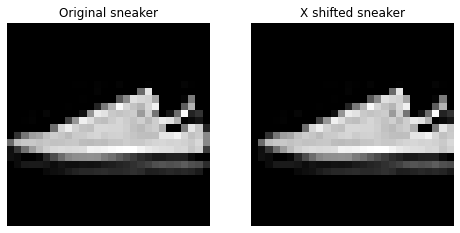

In [52]:
x_shifted_sneaker = ndimage.shift(sneaker, [0,1])
x_shifted_derivative_s = x_shifted_sneaker.reshape(784) - sneaker.view(784).detach().numpy()

fig, axs = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(8)

axs[0].imshow(sneaker, cmap='gray')
axs[0].set_title("Original sneaker")
axs[1].imshow(x_shifted_sneaker, cmap='gray')
axs[1].set_title("X shifted sneaker")

for i in range(2):
    axs[i].axis('off');

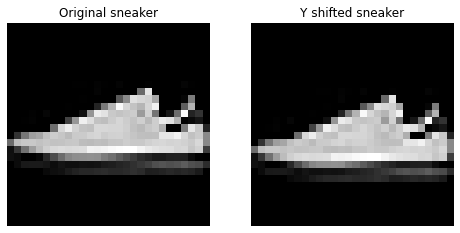

In [53]:
y_shifted_sneaker = ndimage.shift(sneaker, [1,0])
y_shifted_derivative_s = y_shifted_sneaker.reshape(784) - sneaker.view(784).detach().numpy()

fig, axs = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(8)

axs[0].imshow(sneaker, cmap='gray')
axs[0].set_title("Original sneaker")
axs[1].imshow(y_shifted_sneaker, cmap='gray')
axs[1].set_title("Y shifted sneaker")

for i in range(2):
    axs[i].axis('off');

In [54]:
aes_names = ['conv16','conv32','conv128','fc16','fc32','fc128']
aes = [convAE16,convAE32,convAE128,fcAE16,fcAE32,fcAE128]
for i, name in enumerate(aes_names):
    print(name)
    
    if name.startswith('conv'):
        img = sneaker.view(1,1,28,28).to(device)
    else:
        img = sneaker.view(1,784).to(device)

    # Pass base image through autoencoder
    reconstructed_sneaker = aes[i](img).cpu().detach()

    # Rotate reconstructed img
    aux_rotated_sneaker = ndimage.rotate(reconstructed_sneaker.view(28,28), 1, reshape=False)
    aux_rotation_derivative_s = aux_rotated_sneaker.reshape(784) - reconstructed_sneaker.view(784).detach().numpy()

    # Shift reconstructed img on X-axis
    aux_x_shifted_sneaker = ndimage.shift(reconstructed_sneaker.view(28,28), [0,1])
    aux_x_shifted_derivative_s = aux_x_shifted_sneaker.reshape(784) - reconstructed_sneaker.view(784).detach().numpy()

    # Shift reconstructed img on Y-axis
    aux_y_shifted_sneaker = ndimage.shift(reconstructed_sneaker.view(28,28), [1,0])
    aux_y_shifted_derivative_s = aux_y_shifted_sneaker.reshape(784) - reconstructed_sneaker.view(784).detach().numpy()

    rot_projection = project_onto_column_space(Jacobians_sneaker[name], aux_rotation_derivative_s)
    rot_angle = np.arccos(np.dot(rot_projection, aux_rotation_derivative_s) / (np.linalg.norm(rot_projection) * np.linalg.norm(aux_rotation_derivative_s))) * 180 / np.pi
    print(f"Rotation transform angle: {rot_angle}")
    x_shift_projection = project_onto_column_space(Jacobians_sneaker[name], aux_x_shifted_derivative_s)
    x_shift_angle = np.arccos(np.dot(x_shift_projection, aux_x_shifted_derivative_s) / (np.linalg.norm(x_shift_projection) * np.linalg.norm(aux_x_shifted_derivative_s))) * 180 / np.pi
    print(f"X shift transform angle: {x_shift_angle}")
    y_shift_projection = project_onto_column_space(Jacobians_sneaker[name], aux_y_shifted_derivative_s)
    y_shift_angle = np.arccos(np.dot(y_shift_projection, aux_y_shifted_derivative_s) / (np.linalg.norm(y_shift_projection) * np.linalg.norm(aux_y_shifted_derivative_s))) * 180 / np.pi
    print(f"Y shift transform angle: {y_shift_angle}\n")

conv16
Rotation transform angle: 46.94142105211268
X shift transform angle: 40.33191870927762
Y shift transform angle: 21.831229483726915

conv32
Rotation transform angle: 41.25137145458806
X shift transform angle: 31.443373485706076
Y shift transform angle: 19.639689863994743

conv128
Rotation transform angle: 21.61787827971781
X shift transform angle: 21.99466395773427
Y shift transform angle: 12.320641003195732

fc16
Rotation transform angle: 54.31416629884539
X shift transform angle: 60.658991981153285
Y shift transform angle: 19.797074497944763

fc32
Rotation transform angle: 56.59707506665212
X shift transform angle: 59.65022085206659
Y shift transform angle: 20.93315693806591

fc128
Rotation transform angle: 41.75366698124538
X shift transform angle: 42.26243069704671
Y shift transform angle: 16.224996552602107



In [55]:
# Encoding
sneaker_pca16 = sneaker.view(-1) @ principal_components[:16,:].T # 1x784 @ 16x784.T = 1x16
sneaker_pca32 = sneaker.view(-1) @ principal_components[:32,:].T # 1x784 @ 32x784.T = 1x32
sneaker_pca128 = sneaker.view(-1) @ principal_components[:128,:].T # 1x784 @ 128x784.T = 1x128

# Reconstruction
sneaker_rec16 = sneaker_pca16 @ principal_components[:16,:] # 1x16 @ 16x784 = 1x784
sneaker_rec32 = sneaker_pca32 @ principal_components[:32,:] # 1x32 @ 32x784 = 1x784
sneaker_rec128 = sneaker_pca128 @ principal_components[:128,:] # 1x128 @ 128x784 = 1x784

reconstructed_sneakers = [sneaker_rec16, sneaker_rec32, sneaker_rec128]

components = [16,32,128]
for i,c in enumerate(components):
    print(f"PCA {c} components")
    
    # Rotate reconstructed img
    aux_rotated_sneaker = ndimage.rotate(reconstructed_sneakers[i].view(28,28), 1, reshape=False)
    aux_rotation_derivative_p = aux_rotated_sneaker.reshape(784) - reconstructed_sneakers[i].view(784).detach().numpy()

    # Shift reconstructed img on X-axis
    aux_x_shifted_sneaker = ndimage.shift(reconstructed_sneakers[i].view(28,28), [0,1])
    aux_x_shifted_derivative_p = aux_x_shifted_sneaker.reshape(784) - reconstructed_sneakers[i].view(784).detach().numpy()

    # Shift reconstructed img on Y-axis
    aux_y_shifted_sneaker = ndimage.shift(reconstructed_sneakers[i].view(28,28), [1,0])
    aux_y_shifted_derivative_p = aux_y_shifted_sneaker.reshape(784) - reconstructed_sneakers[i].view(784).detach().numpy()

    rot_projection = project_onto_column_space(principal_components[:c,:].T, aux_rotation_derivative_p)
    rot_angle = np.arccos(np.dot(rot_projection, aux_rotation_derivative_p) / (np.linalg.norm(rot_projection) * np.linalg.norm(aux_rotation_derivative_p))) * 180 / np.pi
    print(f"Rotation transform angle: {rot_angle}")
    x_shift_projection = project_onto_column_space(principal_components[:c,:].T, aux_x_shifted_derivative_p)
    x_shift_angle = np.arccos(np.dot(x_shift_projection, aux_x_shifted_derivative_p) / (np.linalg.norm(x_shift_projection) * np.linalg.norm(aux_x_shifted_derivative_p))) * 180 / np.pi
    print(f"X shift transform angle: {x_shift_angle}")
    y_shift_projection = project_onto_column_space(principal_components[:c,:].T, aux_y_shifted_derivative_p)
    y_shift_angle = np.arccos(np.dot(y_shift_projection, aux_y_shifted_derivative_p) / (np.linalg.norm(y_shift_projection) * np.linalg.norm(aux_y_shifted_derivative_p))) * 180 / np.pi
    print(f"Y shift transform angle: {y_shift_angle}\n")

PCA 16 components
Rotation transform angle: 72.17807548822243
X shift transform angle: 70.16223021426259
Y shift transform angle: 37.26364267150664

PCA 32 components
Rotation transform angle: 62.26556614826925
X shift transform angle: 62.79517178994119
Y shift transform angle: 20.017233564843636

PCA 128 components
Rotation transform angle: 40.12236748437631
X shift transform angle: 32.336246114602176
Y shift transform angle: 9.272230884595462



For this case, the convAE128 is more invariant for X translation and rotation transformations than the PCA with 128 components. Again, if we take a look at the plot of the first 128 tangent vectors of the PCA, we can see that the shape of a sneaker is present in some of them, but not all. As I mentioned before, the dominant shape in PCA's tangent vectors is the shape of pullover/shirt/t-shirt, and this would explain why for PCA the sneaker is not as invariant to these transformations as it was the pullover.

A possible explanation of why PCA is still doing a great job for the Y translation transformation for the sneaker could be the following. If we analyze the principal components images, all sneakers shapes seems to have a thick sole, and that may be making the PCA robust or invariant to the Y-shifts for this object.